Taking all previous learnings into consideration: 
- retraining for the timeseries forecasting task

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
from utils.fetch_data import fetch_timeseries_data
from utils.load_data import TimeSeriesDataset
from utils.early_stopping import EarlyStopping

In [2]:
from utils.fetch_data import create_splits

In [3]:
torch.manual_seed(1)

Get the data:

In [4]:
df = fetch_timeseries_data()

In [5]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [6]:
df.shape

(9009, 3)

Some data exploration:...

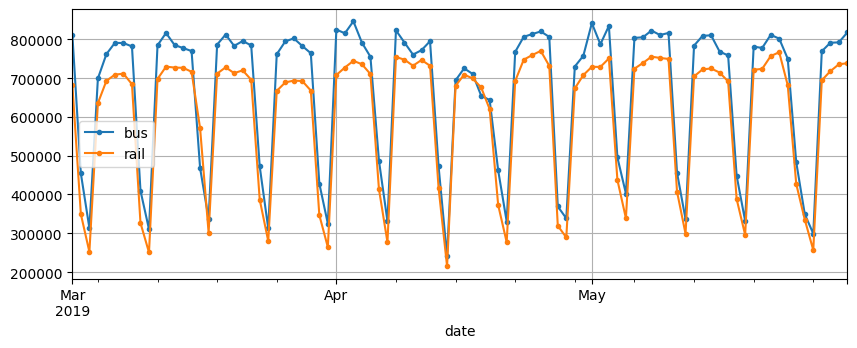

In [8]:
df['2019-03':'2019-05'].plot(grid=True, marker='.',figsize=(10,3.5))
plt.show()

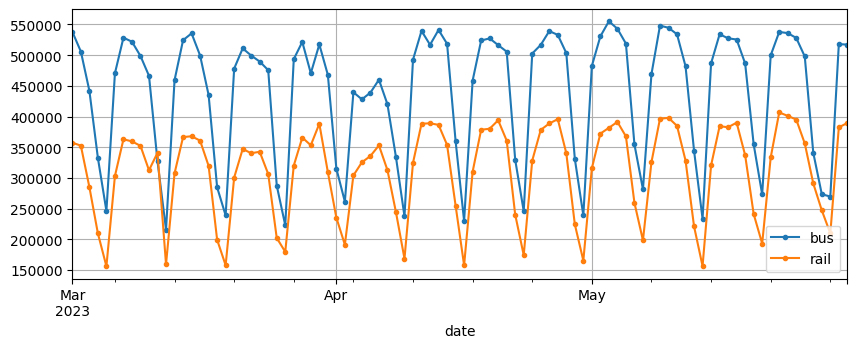

In [9]:
df['2023-03':'2023-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

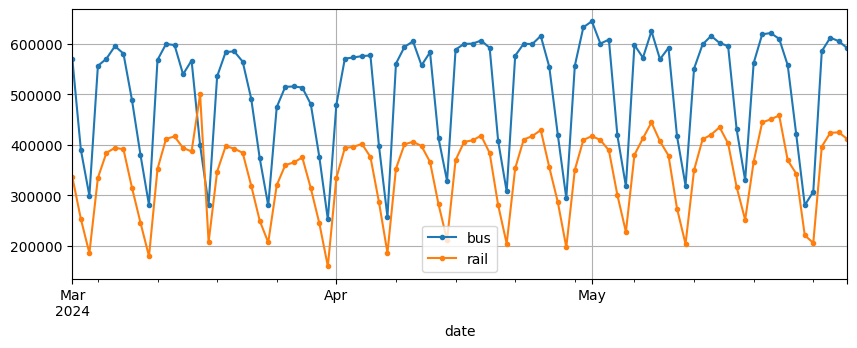

In [10]:
df['2024-03':'2024-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

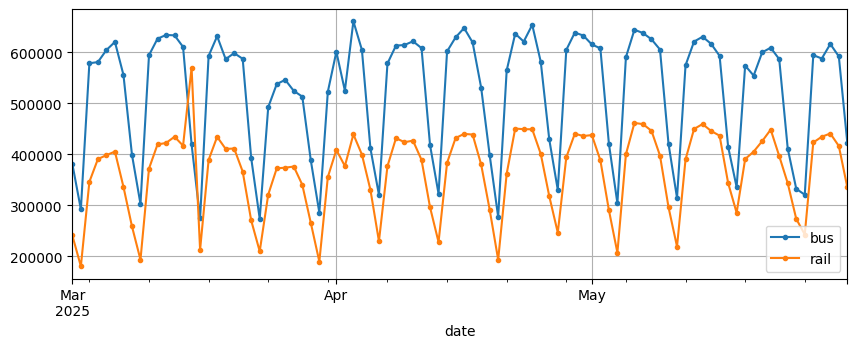

In [11]:
df['2025-03':'2025-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

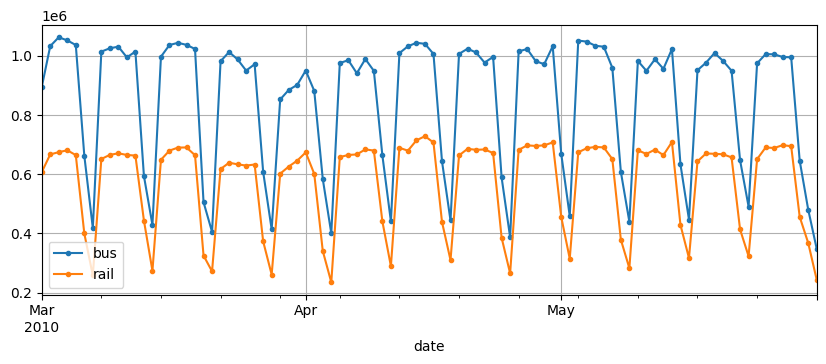

In [12]:
df['2010-03':'2010-05'].plot(grid=True, marker='.', figsize=(10,3.5))
plt.show()

Create training, validation and test splits:

In [13]:
rail_train, rail_valid, rail_test = create_splits(df, attr='rail', train_ran=['2016-01','2024-12'],val_ran=['2025-01','2025-04'],test_ran=['2025-05'])

Attempting to have chunks that forecast 2 weeks ahead (14 days worth of data), and to train with sequence lengths of 56

Need to build and train a sequence to sequence model that uses a sequence of length 56, to pedict the next 14 values. At each timestep, the model therfore should return the next 14 values (forecasting horizon)

In [14]:
seq_length = 56
forecasting_horizon = 14

def create_x_chunks(ds):
    return [ds[i:i+seq_length] for i in range(len(ds)-seq_length-14+1)]

def create_y_chunks(ds):
    y_chunks = []
    for i in range(len(ds)-seq_length-14+1):
        seq_chunk = [ds[i+j+1:i+j+1+forecasting_horizon] for j in range(seq_length)]
        y_chunks.append(seq_chunk)
    return y_chunks

In [15]:
train_x_chunks, train_y_chunks = create_x_chunks(rail_train.values.tolist()), create_y_chunks(rail_train.values.tolist())
valid_x_chunks, valid_y_chunks = create_x_chunks(rail_valid.values.tolist()), create_y_chunks(rail_valid.values.tolist())
test_x_chunks, test_y_chunks = create_x_chunks(rail_test.values.tolist()), create_y_chunks(rail_test.values.tolist())

In [16]:
train_x_chunks, train_y_chunks = torch.tensor(train_x_chunks), torch.tensor(train_y_chunks)
valid_x_chunks, valid_y_chunks = torch.tensor(valid_x_chunks), torch.tensor(valid_y_chunks)
test_x_chunks, test_y_chunks = torch.tensor(test_x_chunks), torch.tensor(test_y_chunks)

In [17]:
train_x_chunks.shape, train_y_chunks.shape

(torch.Size([3219, 56]), torch.Size([3219, 56, 14]))

In [18]:
train_x_chunks[3218,:]

tensor([0.4615, 0.4651, 0.4088, 0.2963, 0.2156, 0.3894, 0.4447, 0.4519, 0.4256,
        0.3818, 0.2813, 0.2279, 0.3832, 0.3791, 0.4280, 0.4507, 0.3963, 0.2889,
        0.2324, 0.3586, 0.4379, 0.4344, 0.4396, 0.3970, 0.3164, 0.2337, 0.3831,
        0.4397, 0.4290, 0.4145, 0.4315, 0.3409, 0.2220, 0.3446, 0.3568, 0.3089,
        0.1324, 0.2246, 0.2176, 0.1752, 0.3492, 0.4059, 0.4110, 0.4016, 0.3715,
        0.2864, 0.2163, 0.3643, 0.4064, 0.3980, 0.3509, 0.3608, 0.2628, 0.1980,
        0.3425, 0.3913])

In [19]:
train_y_chunks[3218,54,:]

tensor([0.3913, 0.3823, 0.3738, 0.3267, 0.2344, 0.1883, 0.2678, 0.1815, 0.0863,
        0.2253, 0.2455, 0.2229, 0.1587, 0.2855])

Create the dataset that will enable batching

In [20]:
class TsDataset(Dataset):
    def __init__(self, x_chunks, y_chunks):
        super().__init__()
        self.x_chunks = x_chunks
        self.y_chunks = y_chunks
    def __len__(self):
        return self.x_chunks.shape[0]
    
    def __getitem__(self, index):
        return self.x_chunks.unsqueeze(2)[index,:,:], self.y_chunks[index,:,:]

In [21]:
train_ds = TsDataset(train_x_chunks, train_y_chunks)
val_ds = TsDataset(valid_x_chunks, valid_y_chunks)
test_ds = TsDataset(test_x_chunks, test_y_chunks)

In [22]:
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)
test_dl = DataLoader(test_ds, batch_size=1024)

Now - time to build the model:
- Stage 1: Use a simple LSTM

In [158]:
torch.manual_seed(1)

In [159]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.input = nn.Linear(input_size, 4*hidden_size,device=device) # instead of breaking this down, could just compute these with one linear layer and break down its results later
        nn.init.xavier_uniform_(self.input.weight.data)
        self.hidden = nn.Linear(hidden_size, 4*hidden_size,device=device) # same for this
        nn.init.xavier_uniform_(self.hidden.weight.data)
        nn.init.zeros_(self.input.bias)
        nn.init.zeros_(self.hidden.bias)

        self.hidden_size = hidden_size
        self.ln_gates = nn.LayerNorm(4*hidden_size,device=device)
        self.ln_c = nn.LayerNorm(hidden_size, device=device)
        self.device = device
    def forward(self, x, prev_h, prev_c):
        computed_inputs = self.input(x)
        computed_hiddens = self.hidden(prev_h)

        gates = self.ln_gates(computed_inputs+computed_hiddens)

        # compute the input gate
        input_gate = torch.sigmoid(gates[:,:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:,self.hidden_size:2*self.hidden_size])
        signal = torch.tanh(gates[:,2*self.hidden_size:3*self.hidden_size])
        output_gate = torch.sigmoid(gates[:,3*self.hidden_size:4*self.hidden_size])
        long_state = forget_gate*prev_c + input_gate*signal
        return output_gate*torch.tanh(self.ln_c(long_state)), long_state

In [160]:
class CustomLSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        self.lstm_cell = CustomLSTMCell(input_size, hidden_size,device)
        self.hidden_size = hidden_size
        self.device = device
    def forward(self, input):
        batch, seq_len, _ = input.shape
        short_term_state = []
        long_term_state = []
        prev_h = torch.zeros((batch, self.hidden_size), device=self.device)
        prev_c = torch.zeros((batch, self.hidden_size), device= self.device)

        for i in range(seq_len):
            xt = input[:,i,:]
            prev_h, prev_c = self.lstm_cell(xt, prev_h, prev_c)
            short_term_state.append(prev_h)
            long_term_state.append(prev_c)
        out = torch.stack(short_term_state, dim=1)
        return out, (prev_h,  prev_c) 

In [242]:
torch.manual_seed(1)

In [243]:
class Seq2SeqUnivar(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super().__init__()
        #self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=1)
        self.lstm = CustomLSTMLayer(input_size, hidden_size,device)
        #nn.init.xavier_uniform_(self.lstm.weight_ih_l0.data)
        #nn.init.xavier_uniform_(self.lstm.weight_hh_l0.data)
        self.linear = nn.Linear(hidden_size, 14)
    def forward(self, input):
        out, (_,_) = self.lstm(input)
        return self.linear(out)

In [244]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [245]:
model = Seq2SeqUnivar(1, 32, device=device).to(device)

In [246]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
criterion = nn.HuberLoss(reduction='sum')
early_stopper = EarlyStopping(patience=50, checkpoint_path='seq2seqx.pt', restore_best_weights=True, verbose=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience=5, factor=0.9)

In [247]:
n_epochs = 1000

train_loss = [0] * n_epochs
val_loss = [0] * n_epochs

for epoch in range(n_epochs):
    model.train()
    # iterate through the training data
    for x_batch, y_batch in train_dl:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(x_batch)
        # adding l1 norm
        norm = sum(p.abs().sum() for p in model.parameters())
        loss = criterion(out, y_batch) + 1e-5*norm
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        train_loss[epoch]+=loss.item()
    train_loss[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        for x_batch,y_batch in val_dl:
            x_batch,y_batch = x_batch.to(device),y_batch.to(device)
            out = model(x_batch)
            loss = criterion(out, y_batch)
            val_loss[epoch] += loss.item()
        val_loss[epoch] /= len(val_dl.dataset)

        scheduler.step(val_loss[epoch])
        print(f'Epoch: {epoch+1}| Train loss: {train_loss[epoch]:.4f}| Val loss: {val_loss[epoch]:.4f}')
        early_stopper(val_loss[epoch], model, optimizer, epoch)
        if early_stopper.should_stop:
            print(f"Stopping at epoch: {epoch+1}")
            break

Epoch: 1| Train loss: 35.9125| Val loss: 6.2010
Metric improved to 6.2010. Checkpoint saved at epoch 0
Epoch: 2| Train loss: 9.6824| Val loss: 4.7600
Metric improved to 4.7600. Checkpoint saved at epoch 1
Epoch: 3| Train loss: 8.0063| Val loss: 3.8098
Metric improved to 3.8098. Checkpoint saved at epoch 2
Epoch: 4| Train loss: 7.5862| Val loss: 3.3529
Metric improved to 3.3529. Checkpoint saved at epoch 3
Epoch: 5| Train loss: 7.3933| Val loss: 3.4022
No improvement for 1 epoch(s)
Epoch: 6| Train loss: 7.2845| Val loss: 3.4114
No improvement for 2 epoch(s)
Epoch: 7| Train loss: 7.1659| Val loss: 3.4878
No improvement for 3 epoch(s)
Epoch: 8| Train loss: 6.9944| Val loss: 3.2737
Metric improved to 3.2737. Checkpoint saved at epoch 7
Epoch: 9| Train loss: 6.6113| Val loss: 2.8536
Metric improved to 2.8536. Checkpoint saved at epoch 8
Epoch: 10| Train loss: 5.5390| Val loss: 2.5504
Metric improved to 2.5504. Checkpoint saved at epoch 9
Epoch: 11| Train loss: 4.5466| Val loss: 2.3784
Metri

In [248]:
l1_loss = nn.L1Loss(reduction='mean')
loss_ = []

with torch.no_grad():
    model.eval()
    for x_batch, y_batch in test_dl:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        out = model(x_batch)
        loss = l1_loss(out, y_batch)
        loss_.append(loss.item())
        break

In [249]:
(sum(loss_)/len(loss_)) * 1e6

31766.556203365326

Testing out the predictions on the test set:

In [250]:
model.eval()

Seq2SeqUnivar(
  (lstm): CustomLSTMLayer(
    (lstm_cell): CustomLSTMCell(
      (input): Linear(in_features=1, out_features=128, bias=True)
      (hidden): Linear(in_features=32, out_features=128, bias=True)
      (ln_gates): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln_c): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
  )
  (linear): Linear(in_features=32, out_features=14, bias=True)
)

In [251]:
pred_set = torch.tensor(rail_test.iloc[:56].values.tolist(), device=device).reshape(1,56,1)

In [ ]:
with torch.no_grad():
    model.eval()
    prediction = model(pred_set)

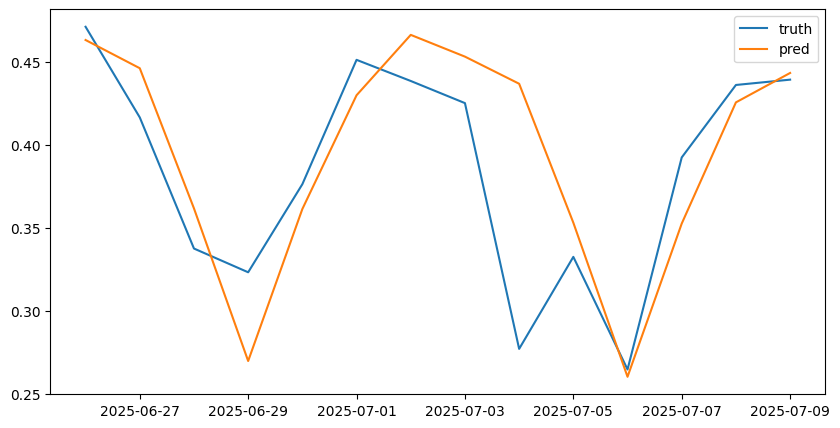

In [253]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(rail_test.iloc[56:56+14],label='truth')
ax.plot(
    pd.Series(
    prediction[-1, -1, :].detach().cpu().numpy(),
    index = rail_test.iloc[56:56+14].index
),label='pred'
)
ax.legend()